In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import acquire as a
import prepare as p

In [2]:
#acquire data
df = a.get_all_data()
df = p.prep_store_data(df)
df.head()

,item_id,sale_amount,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_state,store_zipcode,month,weekday,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,13.0,1,1,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,01-Jan,2-Tue,10.92
2013-01-01 00:00:00+00:00,17,26.0,295813,3,Ducal,Ducal Refried Red Beans,1.16,88313590791,88313590791,2118 Fredericksburg Rdj,San Antonio,TX,78201,01-Jan,2-Tue,30.16
2013-01-01 00:00:00+00:00,7,32.0,125995,10,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,70177154004,70177154004,8503 NW Military Hwy,San Antonio,TX,78231,01-Jan,2-Tue,308.48
2013-01-01 00:00:00+00:00,18,45.0,314073,3,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,21200725340,21200725340,2118 Fredericksburg Rdj,San Antonio,TX,78201,01-Jan,2-Tue,197.55
2013-01-01 00:00:00+00:00,19,34.0,332333,3,Careone,Careone Family Comb Set - 8 Ct,0.74,41520035646,41520035646,2118 Fredericksburg Rdj,San Antonio,TX,78201,01-Jan,2-Tue,25.16


Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:

Simple Average

Moving Average

Holt's Linear Trend Model

Based on previous year/month/etc., this is up to you.

In [3]:
df = df.resample('w').agg('sum')
df.head()

,item_id,sale_amount,sale_id,store_id,item_price,item_upc12,item_upc14,store_zipcode,sales_total
sale_date,,,,,,,,,
2013-01-06 00:00:00+00:00,76500,91067.0,1366771500,16500,15481.2,715406353473120,715406353473120,234674400,490767.50
2013-01-13 00:00:00+00:00,89250,103902.0,1594589500,19250,18061.4,834640745718640,834640745718640,273786800,559934.21
2013-01-20 00:00:00+00:00,89250,102950.0,1594614000,19250,18061.4,834640745718640,834640745718640,273786800,552813.52
2013-01-27 00:00:00+00:00,89250,103298.0,1594638500,19250,18061.4,834640745718640,834640745718640,273786800,554908.84
2013-02-03 00:00:00+00:00,89250,109027.0,1594663000,19250,18061.4,834640745718640,834640745718640,273786800,586547.55


In [4]:
#define function for splitting data

def split_store_data(df, train_prop=.66): 
    train_size = int(len(df) * train_prop)
    train, test = df[0:train_size], df[train_size:len(df)]
    return train, test

In [5]:
#call function to split data
train, test = split_store_data(df, train_prop=.66)

In [6]:
print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 261
Training Observations: 172
Testing Observations: 89


In [7]:
train.head()

,item_id,sale_amount,sale_id,store_id,item_price,item_upc12,item_upc14,store_zipcode,sales_total
sale_date,,,,,,,,,
2013-01-06 00:00:00+00:00,76500,91067.0,1366771500,16500,15481.2,715406353473120,715406353473120,234674400,490767.50
2013-01-13 00:00:00+00:00,89250,103902.0,1594589500,19250,18061.4,834640745718640,834640745718640,273786800,559934.21
2013-01-20 00:00:00+00:00,89250,102950.0,1594614000,19250,18061.4,834640745718640,834640745718640,273786800,552813.52
2013-01-27 00:00:00+00:00,89250,103298.0,1594638500,19250,18061.4,834640745718640,834640745718640,273786800,554908.84
2013-02-03 00:00:00+00:00,89250,109027.0,1594663000,19250,18061.4,834640745718640,834640745718640,273786800,586547.55


In [8]:
train = train[['sale_amount']]
test = test[['sale_amount']]

In [17]:
train.head()

,sale_amount
sale_date,
2013-01-06 00:00:00+00:00,91067.0
2013-01-13 00:00:00+00:00,103902.0
2013-01-20 00:00:00+00:00,102950.0
2013-01-27 00:00:00+00:00,103298.0
2013-02-03 00:00:00+00:00,109027.0


In [18]:
test.head()

,sale_amount
sale_date,
2016-04-24 00:00:00+00:00,208917.0
2016-05-01 00:00:00+00:00,212214.0
2016-05-08 00:00:00+00:00,224659.0
2016-05-15 00:00:00+00:00,223528.0
2016-05-22 00:00:00+00:00,224161.0


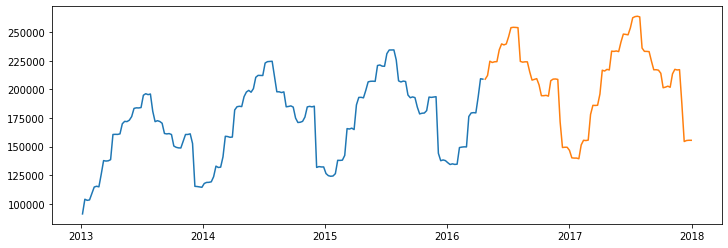

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(train)
plt.plot(test)
plt.show()

In [10]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

In [11]:
def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train')
    plt.plot(test[target_vars], label='Test')

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [12]:
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

In [19]:
yhat = pd.DataFrame(test.sale_amount)

In [26]:
train['y_last_value'] = int(train.sale_amount[-1:])

In [28]:
train['y_mean'] = train.sale_amount.mean()

In [34]:
train['y_moving_average'] = train.sale_amount.rolling(1).mean().iloc[-1]

In [51]:
model = Holt(train['sale_amount']).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)

train['holts_linear_y'] = pd.DataFrame(model.forecast(test['sale_amount'].shape[0]), columns=['sale_amount'])

In [54]:
model = Holt(train['sale_amount'], exponential=True).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)

train['holts_exp_y'] = pd.DataFrame(model.forecast(test['sale_amount'].shape[0]), columns=['sale_amount'])

In [55]:
train.head()

,sale_amount,y_last_value,y_mean,y_moving_average,holts_linear_y,holts_exp_y
sale_date,,,,,,
2013-01-06 00:00:00+00:00,91067.0,208943,169421.854651,208943.0,NaN,NaN
2013-01-13 00:00:00+00:00,103902.0,208943,169421.854651,208943.0,NaN,NaN
2013-01-20 00:00:00+00:00,102950.0,208943,169421.854651,208943.0,NaN,NaN
2013-01-27 00:00:00+00:00,103298.0,208943,169421.854651,208943.0,NaN,NaN
2013-02-03 00:00:00+00:00,109027.0,208943,169421.854651,208943.0,NaN,NaN
